# Playground for generating samples with CNN encoder VAE

In [2]:
# import the required libraries
import numpy as np
import time
import random
import cPickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange
%load_ext autoreload
%autoreload 2

#os.environ["CUDA_VISIBLE_DEVICES"]="1"

# libraries required for visualisation:
from IPython.display import SVG, display
import svgwrite # conda install -c omnia svgwrite=1.1.6
import PIL
from PIL import Image
import matplotlib.pyplot as plt
% matplotlib inline

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# import our command line tools
from sketch_rnn_train_cnn_tf import *
from model_cnn_tf import *
from utils import *
from rnn import *
from cnn_tf import *

In [4]:
# little function that displays vector images and saves them to .svg
def draw_strokes(data, color="black", doGradient=False, endColor="black", factor=0.2, svg_filename = 'svg/sample.svg'):
    tf.gfile.MakeDirs(os.path.dirname(svg_filename))
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
    lift_pen = 1
    abs_x = 25 - min_x 
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)
    command = "m"
    for i in xrange(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i,0])/factor
        y = float(data[i,1])/factor
        lift_pen = data[i, 2]
        p += command+str(x)+","+str(y)+" "
    
    the_color = color
    stroke_width = 1
    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
    dwg.save()
    display(SVG(dwg.tostring()))
    

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]

  #for each reconstruction
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

In [5]:
def draw_strokes_gradient(data, n, n_examples, factor = .2):
    
    x = 0
    y = 0
    s = 0
    imagex = [[x]]
    imagey = [[y]]
    for i in range(len(data)):
        x += data[i][0]*factor
        y += data[i][1]*factor
        imagex[s].append(x)
        imagey[s].append(y)
        if data[i][2] == 1:
            s += 1
            imagex.append([])
            imagey.append([])
    
    n_strokes = len(imagex)
    plt.subplot(1,n_examples,n+1)
    plt.gca().invert_yaxis()
    plt.axis("off")
    plt.axis("equal")
    colors = [(.1 + j*.9/n_strokes, .15, 1 - j*.9/n_strokes) for j in range(n_strokes)]
    for j in range(n_strokes):
        plt.plot(imagex[j], imagey[j], color = colors[j], linewidth = 1)

(30000, 48, 48)


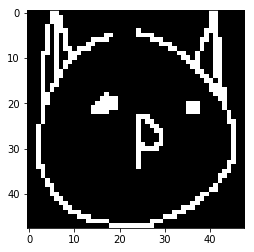

In [6]:
#LOAD DATA FOR CNN
cat = np.load('datasets/cnn/cat_half.npy')
train_cat = cat[0]/255.
# mosquito = np.load('cnn/mosquito.npy')
print(np.shape(train_cat))
# reshape data
train_cat = np.reshape(train_cat, (train_cat.shape[0], 48, 48, 1)).astype('float32')
# mosquito = np.reshape(mosquito, (mosquito.shape[0], 28, 28, 1)).astype('float32')/255.

i = np.random.randint(0, train_cat.shape[0])
plt.imshow(np.squeeze(train_cat[i,:,:,:]),cmap='gray')
plt.show()


In [7]:
def encode(input_strokes):
  strokes = to_big_strokes(input_strokes).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  print(seq_len)
  draw_strokes(to_normal_strokes(np.array(strokes)))
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]
    

def encode_cnn(input_ims):
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_ims: [input_ims]})[0]

#latent vector to stroke
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m, _, _ = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor=factor)
  return strokes

In [8]:
model_dir = 'checkpoint_path/four_class_cnn'
[hps_model, eval_hps_model, sample_hps_model] = load_model(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Loading model checkpoint_path/four_class_cnn/vector-70000.
INFO:tensorflow:Restoring parameters from checkpoint_path/four_class_cnn/vector-70000


INFO:tensorflow:Loading model checkpoint_path/four_class_cnn/vector-70000.
INFO:tensorflow:Restoring parameters from checkpoint_path/four_class_cnn/vector-70000


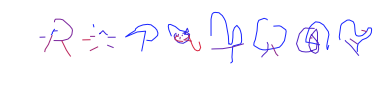

In [9]:
# randomly unconditionally generate N examples
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)
N = 8
fig = plt.subplots(nrows=1, ncols=N, figsize=(6,1))
reconstructions = []

for i in range(N):
    sample_strokes, m, hidden_states, final_x = sample(sess, sample_model, temperature=.7)
    strokes = to_normal_strokes(sample_strokes)
    draw_strokes_gradient(strokes, i, N)
#plt.savefig('results/progress/mosquito_recon_5000.pdf', bbox_inches='tight')


In [14]:
# load datasets
data_dir = 'datasets/datasets/'
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env(data_dir, model_dir)
[train_ims, valid_ims, test_ims] = load_env_ims(data_dir, model_dir)

INFO:tensorflow:Loaded 10000/2500/2500 from cactus_10k.npz
INFO:tensorflow:Loaded 10000/2500/2500 from mosquito_10k.npz
INFO:tensorflow:Loaded 10000/2500/2500 from mona_lisa_10k.npz
INFO:tensorflow:Loaded 10000/2500/2500 from cat_10k.npz
INFO:tensorflow:Dataset combined: 60000 (40000/10000/10000), avg len 64
INFO:tensorflow:model_params.max_seq_len 150.
total images <= max_seq_len is 40000
total images <= max_seq_len is 10000
total images <= max_seq_len is 10000
INFO:tensorflow:normalizing_scale_factor 47.7898.
INFO:tensorflow:Loaded 10000/2500/2500 from cactus_10k.npy
INFO:tensorflow:Loaded 10000/2500/2500 from mosquito_10k.npy
INFO:tensorflow:Loaded 10000/2500/2500 from mona_lisa_10k.npy
INFO:tensorflow:Loaded 10000/2500/2500 from cat_10k.npy


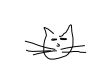

(76, 3)


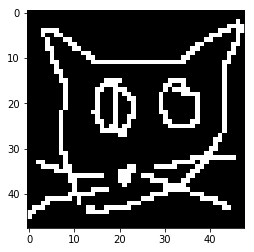

(128,)


In [40]:
# get a sample drawing from the test set, and render it to .svg
i = np.random.randint(0,20000)
stroke = np.copy(test_set.strokes[i])
draw_strokes(stroke)
print(np.shape(stroke))

im = np.copy(test_ims[i,:,:]).astype('float32')
plt.imshow(np.squeeze(im),cmap='gray')
plt.show()

z = encode_cnn(im)
print(np.shape(z))

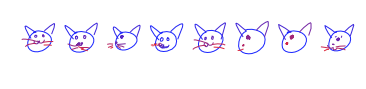

In [41]:
# decode 
N = 8
fig = plt.subplots(nrows=1, ncols=N, figsize=(6,1))
for i in range(N):
    strokes = decode(z, draw_mode = False, temperature=0.2)
    draw_strokes_gradient(strokes, i, N)
    

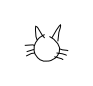

In [84]:
# First random samples
i = np.random.randint(0,10000)
stroke_0 = np.copy(test_set.strokes[i])
draw_strokes(stroke_0)
im_0 = np.copy(test_ims[i,:,:]).astype('float32')
z_0 = encode_cnn(im_0)


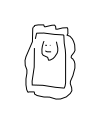

In [78]:
# Second random sample
i = np.random.randint(0,10000)
stroke_1 = np.copy(test_set.strokes[i])
draw_strokes(stroke_1)
im_1 = np.copy(test_ims[i,:,:]).astype('float32')
z_1 = encode_cnn(im_1)

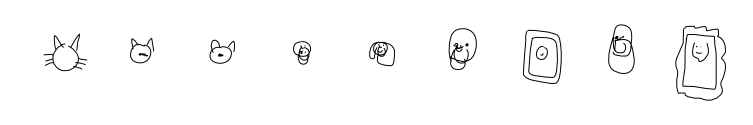

In [87]:
# interpolation
z_list = [] # interpolate spherically between z0 and z1
N = 8
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_0, z_1, t))

# for every latent vector in z_list, sample a vector image
reconstructions = []
reconstructions.append([stroke_0, [0, 0]])
for i in range(1,N):
  reconstructions.append([decode(z_list[i], draw_mode=False), [0, i]])
reconstructions.append([stroke_1, [0, N]])

stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid,factor=0.2, svg_filename = 'svg/cnn_interp_1.svg')

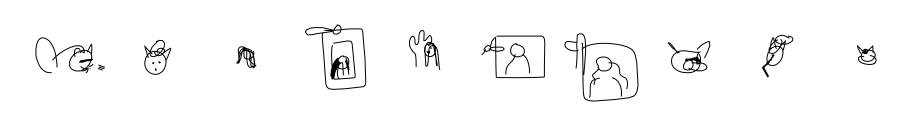

In [102]:
reconstructions = []
N=10
for i in range(N):
    # RANDOM SAMPLES
    j = np.random.randint(0,5000)
    stroke_0 = np.copy(test_set.strokes[j])
    im_0 = np.copy(test_ims[j,:,:]).astype('float32')
    z_0 = encode_cnn(im_0)

    
    j = np.random.randint(5000,10000)
    stroke_1 = np.copy(test_set.strokes[j])
    im_1 = np.copy(test_ims[j,:,:]).astype('float32')
    z_1 = encode_cnn(im_1)
    
    
    #DRAW FIRST PART OF SKETCH
    #get some sample strokes
    sample_strokes_1, m, hidden_states, _ = sample(sess, sample_model, z=[z_0], 
                                                         seq_len=100, temperature=0.2) #final_state,final_x
    n_strokes = np.round(len(sample_strokes_1)/3)
    sample_strokes_part = sample_strokes_1[:n_strokes]
    # strokes_part = to_normal_strokes(sample_strokes_part)
    # sketch_part = draw_strokes(strokes_part, factor=0.2)
    # strokes_full = to_normal_strokes(sample_strokes_1)

    final_state = hidden_states[n_strokes]

    # SWITCH Z VECTOR
    # Encode generated strokes to a hidden state h
    _, hidden_states = get_hidden_states(sess=sess, model=sample_model, input_strokes = sample_strokes_part, z=[z_1], prev_x = final_x)
    input_state = hidden_states[-1]


    sample_strokes_2, _, _, _ = sample(sess=sess, model=sample_model, z=[z_1], temperature=0.1, prev_state = input_state)
    all_strokes_big = np.concatenate((sample_strokes_part,sample_strokes_2),axis=0)
    all_strokes = to_normal_strokes(all_strokes_big)
    reconstructions.append([all_strokes, [0, i]])
    
    
stroke_grid = make_grid_svg(reconstructions, grid_space_x = 16)
draw_strokes(stroke_grid, factor=0.18, svg_filename = 'svg/zswitch_cnn.svg')